In [1]:
import numpy as np
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define some helper functions
def normal_pdf(x, m, s):
    return 1./np.sqrt(2*np.pi*s**2) * np.exp(-1./2 * (x-m)**2 / s**2)

In [3]:
# First, sample a Gaussian mixture model
# This illustrates the "generative" model
def sample_gmm(N, weights, means, var):
    K = len(weights)
    assert len(means) == K
    
    Z = np.zeros(N)
    X = np.zeros(N)
    for n in range(N):
        # Sample mixture component
        Z[n] = np.random.choice(K, p=weights)
        
        # Sample value of the n-th datapoint
        X[n] = np.random.normal(means[Z[n]], np.sqrt(var))
        
    return Z, X
    

/Users/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


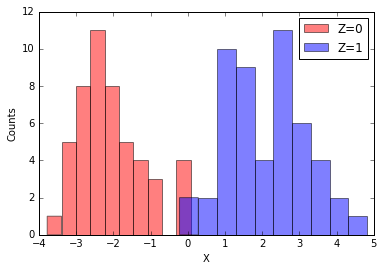

In [4]:
# Try it out!
var = 1.0
weights = np.array([0.5, 0.5])
means = np.array([-2.0, +2.0])

N = 100
Z_true, X = sample_gmm(N, weights, means, var)

plt.figure(figsize=(6,4))
plt.hist(X[Z_true==0], 10, color='r', alpha=0.5, label="Z=0")
plt.hist(X[Z_true==1], 10, color='b', alpha=0.5, label="Z=1")
plt.xlabel("X")
plt.ylabel("Counts")
plt.legend(loc="upper right")


# Bayesian Inference

In [5]:
# What's unknown?
# For each class k:
#   - mean:    \mu_k
#   - weight:  w_k
#
# For each data point:
#   - label:   z_n

# Hyperparameters
K = 2      # Number of classes
m0 = 0.0   # mean of the means
v0 = 1.0   # variance of the means
var = 1.0  # variance of the observations, X[n]

# Initialize the state of the algorithm
means = np.random.normal(m0 * np.ones(K), np.sqrt(v0) * np.ones(K))
weights = np.array([0.5, 0.5])
Z = np.random.choice(K, size=N, p=weights)

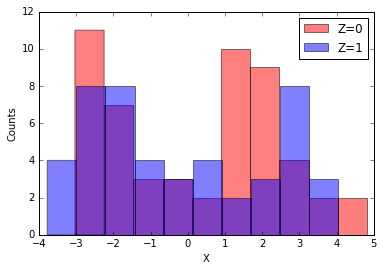

In [6]:
# Plot the initial estimates
plt.figure(figsize=(6,4))
plt.hist(X[Z==0], 10, color='r', alpha=0.5, label="Z=0")
plt.hist(X[Z==1], 10, color='b', alpha=0.5, label="Z=1")
plt.xlabel("X")
plt.ylabel("Counts")
plt.legend(loc="upper right")

In [8]:
N_iter = 1000
for itr in tqdm.tqdm(range(N_iter)):
    # 1. Sample labels given the means and the weights
    for n in range(N):
        # Since we know X[n], this should tell us whether
        # class zero or class one is more likely
        pn = np.zeros(K)
        for k in range(K):
            # What's the probability that X[n] came from 
            # class k?  Intuitively...
            # pn[k] \propto N(X[n] | means[k], stds) * weights[k]
            # 
            # N(x | m, s) = 1/sqrt(2*pi*s**2) * exp(-1/2 (x-m)**2 / s**2)
            pn[k] = normal_pdf(X[n], means[k], np.sqrt(var))
            pn[k] *= weights[k]
            
        # Normalize pn so that it sums to one
        pn = pn / np.sum(pn)
            
        # Now we can sample Z[n] from its *conditional* 
        # distribution given X[n], means, weights
        Z[n] = np.random.choice(K, p=pn)
    
    # 2. Sample means given the labels
    for k in range(K):
        # Compute the conditional distribution of means[k]
        # given X, Z, and the prior, m0, v0
        # p(means[k]) \propto 
        #     \prod_n N(X[n] | Z[n]==k, means[k], std) * N(means[k] | m0, v0)
        # 
        # TODO: Derive the mean and variance of the conditional distribution
        # 
        # Trust me... as I write down the mean and variance of means[k] 
        # under the conditional distribution. 
        Nk = np.sum(Z==k)
        vk = 1./(1./v0 + Nk/var)
        mk = vk * (m0/v0 + X[Z==k].sum() / var)
        
        # Sample from the conditional normal distribution
        means[k] = np.random.normal(mk, np.sqrt(vk))
        
        # Note that when v0 goes to infinity, vk goes to std**2 / Nk
        # and mk goes to X[Z==k].mean(). This shows why it makes sense
        # to just set means[k] as we did before:
        # means[k] = X[Z==k].mean() 
    
    # 3. Sample weights given the labels
    # TODO: Give the weights a "Dirichlet" prior distribution
    for k in range(K):
        weights[k] = np.sum(Z==k) / float(N)
        
    # 4. Calculate the log probability under the current parameters
    # TODO

100%|██████████| 1000/1000 [00:04<00:00, 223.41it/s]


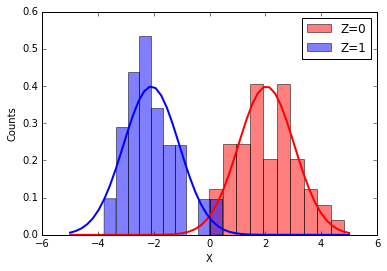

In [10]:
# So... let's look at mixture distributions
colors = ['r', 'b']
plt.figure(figsize=(6,4))
xx = np.linspace(-5,5)
for k in range(K):
    plt.hist(X[Z==k], 10, color=colors[k], alpha=0.5, 
             label="Z={}".format(k), normed=True)
    plt.plot(xx, normal_pdf(xx, means[k], np.sqrt(var)), 
             color=colors[k], linewidth=2)
    
plt.xlabel("X")
plt.ylabel("Counts")
plt.legend(loc="upper right")

# Next Steps
1. This final plot doesn't actually illustrate the real advantage 
   of what we've done! We just plotted the final values of $Z$ and $means[k]$,
   but really, we had 1000 samples of those values. Together, these give
   us a sense of the _posterior uncertainty_ of our estimates. 
   
2. How do we know how many iterations to run? The log probability of
   the data and model parameters (means and weights) is a good starting point.
   If this is still going up, then we haven't converged to good parameters yet.
   If it has flattened out, then we are probably good to go.
   
3. We haven't looked at prior distributions over the weights yet. Let's 
   do that next time!